In [1]:
import os
import json
import numpy as np
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor, Resize
from torch.utils.data import DataLoader, Subset, Dataset
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from PIL import Image
import random
# Set random seeds
torch.manual_seed(42)
random.seed(42)

# Device-agnostic setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print(f"Using device: {device}")

Using GPU: NVIDIA GeForce RTX 3050 Laptop GPU


In [2]:
device

device(type='cuda')

In [3]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [4]:
# Category mapping
category_names = {'pedestrian': 1, 'rider': 2, 'car': 3, 'truck': 4, 'bus': 5,
                  'train': 6, 'motorcycle': 7, 'bicycle': 8, 'traffic light': 9, 'traffic sign': 10}
id_to_category = {v: k for k, v in category_names.items()}

# Simple Dataset
class BDD100KDataset(Dataset):
    def __init__(self, img_root, label_root):
        self.img_root = img_root
        self.label_root = label_root
        self.imgs = sorted([f for f in os.listdir(img_root) if f.endswith('.jpg')])
        self.labels = sorted([f for f in os.listdir(label_root) if f.endswith('.json')])
        print(f"Loaded {len(self.imgs)} image-label pairs")

    def __getitem__(self, index):
        img_path = os.path.join(self.img_root, self.imgs[index])
        label_path = os.path.join(self.label_root, self.labels[index])
        try:
            img = Image.open(img_path).convert('RGB')
            img = ToTensor()(img)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            img = torch.zeros((3, 720, 1280))  # Fallback size
        try:
            with open(label_path, 'r') as f:
                ann = json.load(f)
        except Exception as e:
            print(f"Error loading {label_path}: {e}")
            ann = {'frames': [{'objects': []}]}
        boxes = []
        labels = []
        for obj in ann.get('frames', [{}])[0].get('objects', []):
            category = obj.get('category')
            if category in category_names:
                box2d = obj.get('box2d', {})
                if all(k in box2d for k in ['x1', 'y1', 'x2', 'y2']):
                    boxes.append([box2d['x1'], box2d['y1'], box2d['x2'], box2d['y2']])
                    labels.append(category_names[category])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
        target = {'boxes': boxes, 'labels': labels, 'image_id': torch.tensor([index])}
        return img, target

    def __len__(self):
        return len(self.imgs)


In [13]:
# Define your custom predictor
class CustomBoxPredictor(nn.Module):
    def __init__(self, in_features, num_classes):
        super().__init__()
        self.shared_fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_features, 1024),
            nn.ReLU()
        )
        self.cls_score = nn.Linear(1024, num_classes)
        self.bbox_pred = nn.Linear(1024, num_classes * 4)

    def forward(self, x):
        x = self.shared_fc(x)
        scores = self.cls_score(x)
        bbox_deltas = self.bbox_pred(x)
        return scores, bbox_deltas

# Wrap it in a class to match torchvision API
class CustomFasterRCNN(FasterRCNN):
    def __init__(self, num_classes):
        # FPN backbone (outputs 5 levels by default: '0', '1', '2', '3', 'pool')
        backbone = resnet_fpn_backbone('resnet50', pretrained=False)

        # Correct anchor generator for 5 feature maps
        anchor_generator = AnchorGenerator(
            sizes=((32,), (64,), (128,), (256,), (512,)),
            aspect_ratios=((0.5, 1.0, 2.0),) * 5
        )

        # RoI pooling config
        roi_pooler = torchvision.ops.MultiScaleRoIAlign(
            featmap_names=['0', '1', '2', '3'],  # use only 4 feature maps (optional)
            output_size=7,
            sampling_ratio=2
        )

        # Init FasterRCNN
        super().__init__(backbone,
                         num_classes=num_classes,
                         rpn_anchor_generator=anchor_generator,
                         box_roi_pool=roi_pooler)

        # Replace box predictor
        in_features = self.roi_heads.box_predictor.cls_score.in_features
        self.roi_heads.box_predictor = CustomBoxPredictor(in_features, num_classes)
    def forward(self, images, targets=None):
        # Call the standard Faster R-CNN forward
        return super().forward(images, targets)

In [6]:
# Load datasets
img_root = r'C:\Users\nandi\OneDrive\Desktop\SUNY BUFFALO SUM SEM DL\Final Project\bdd100k\images'  # Update this
label_root = r'C:\Users\nandi\OneDrive\Desktop\SUNY BUFFALO SUM SEM DL\Final Project\bdd100k\labels'  # Update this
train_dataset = BDD100KDataset(os.path.join(img_root, 'train'), os.path.join(label_root, 'train'))
val_dataset = BDD100KDataset(os.path.join(img_root, 'val'), os.path.join(label_root, 'val'))


# Create subsets
train_subset = Subset(train_dataset, random.sample(range(len(train_dataset)), min(50, len(train_dataset))))
val_subset = Subset(val_dataset, random.sample(range(len(val_dataset)), min(10, len(val_dataset))))
print(f'Train subset size: {len(train_subset)}')
print(f'Validation subset size: {len(val_subset)}')

Loaded 70000 image-label pairs
Loaded 10000 image-label pairs
Train subset size: 50
Validation subset size: 10


In [7]:
# Dataset statistics
def get_dataset_stats(dataset):
    category_counts = {}
    box_counts = []
    for i in range(len(dataset)):
        try:
            _, target = dataset[i]
            labels = target['labels'].numpy()
            for label in labels:
                category_counts[label] = category_counts.get(label, 0) + 1
            box_counts.append(len(labels))
        except Exception as e:
            print(f"Error processing index {i}: {e}")
    return {'num_images': len(dataset), 'category_counts': category_counts, 'avg_boxes_per_image': np.mean(box_counts) if box_counts else 0}

train_stats = get_dataset_stats(train_subset)
val_stats = get_dataset_stats(val_subset)

print('Train Stats:')
print(f'Images: {train_stats["num_images"]}, Avg boxes/image: {train_stats["avg_boxes_per_image"]:.2f}')
for cat_id, count in train_stats['category_counts'].items():
    print(f'  {id_to_category.get(cat_id, cat_id)}: {count}')

print('\nVal Stats:')
print(f'Images: {val_stats["num_images"]}, Avg boxes/image: {val_stats["avg_boxes_per_image"]:.2f}')
for cat_id, count in val_stats['category_counts'].items():
    print(f'  {id_to_category.get(cat_id, cat_id)}: {count}')

Train Stats:
Images: 50, Avg boxes/image: 14.78
  car: 454
  traffic sign: 159
  bus: 14
  traffic light: 87
  truck: 23
  rider: 2

Val Stats:
Images: 10, Avg boxes/image: 14.50
  car: 92
  traffic sign: 29
  truck: 6
  traffic light: 17
  bus: 1


Visualizing 3 images...


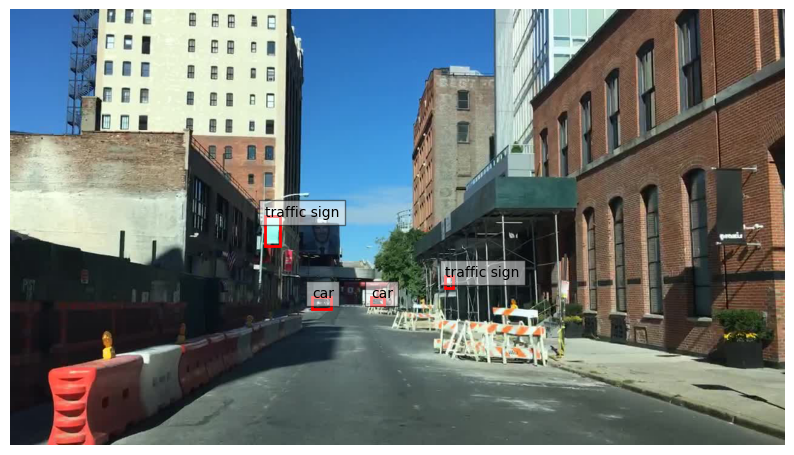

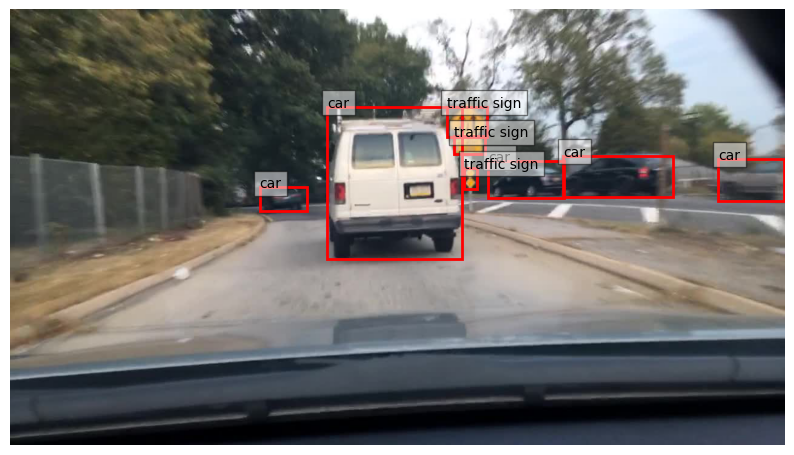

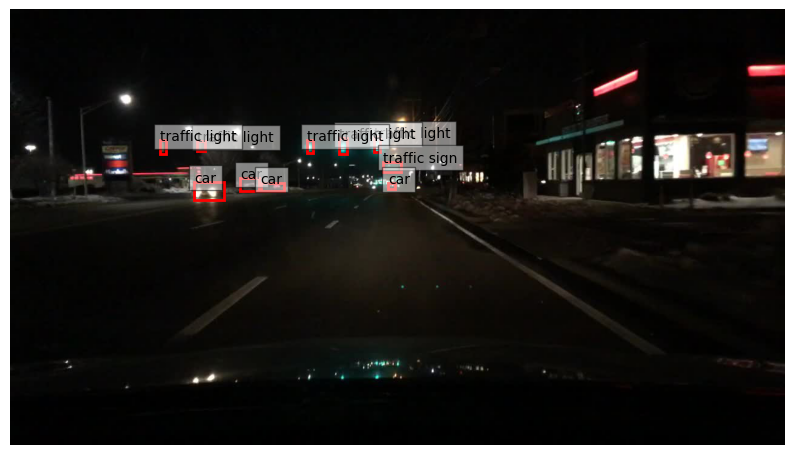

In [8]:
# Visualize images (placeholder)
def visualize_image(dataset, idx):
    try:
        img, target = dataset[idx]
        img = img.permute(1, 2, 0).numpy()
        boxes = target['boxes'].numpy()
        labels = target['labels'].numpy()
        plt.figure(figsize=(10, 6))
        plt.imshow(img)
        ax = plt.gca()
        for box, label in zip(boxes, labels):
            x1, y1, x2, y2 = box
            rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2)
            ax.add_patch(rect)
            ax.text(x1, y1, id_to_category.get(label, label), bbox=dict(facecolor='white', alpha=0.5))
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Vis error {idx}: {e}")

print("Visualizing 3 images...")
for i in random.sample(range(len(train_subset)), min(3, len(train_subset))):
    visualize_image(train_subset, i)

In [9]:
# DataLoaders
def collate_fn(batch):
    return tuple(zip(*batch))

# train_loader = DataLoader(train_subset, batch_size=1, shuffle=True, num_workers=2, collate_fn=collate_fn, pin_memory=True)
# val_loader = DataLoader(val_subset, batch_size=1, shuffle=False, num_workers=2, collate_fn=collate_fn, pin_memory=True)
dataloaders = {
    'train': DataLoader(train_subset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x))),
    'val': DataLoader(val_subset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
}

# print(f'Train batches: {len(train_loader)}, Val batches: {len(val_loader)}')

In [14]:
# Instantiate model
num_classes = 11  # For example: 10 classes + background
model = CustomFasterRCNN(num_classes=num_classes)

# Move to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
print('Model initialized on device')


Model initialized on device


In [ ]:
import torch
import time
import copy
import torchvision
from tqdm import tqdm

def train_model(model, dataloaders, optimizer, num_epochs=10, device='cuda'):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float("inf")

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        print("-" * 30)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                if phase not in dataloaders:
                    continue
                model.eval()

            running_loss = 0.0

            for images, targets in tqdm(dataloaders[phase]):
                images = [img.to(device) for img in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    if phase == 'train':
                        # Training mode: returns loss dict
                        loss_dict = model(images, targets)
                        losses = sum(loss for loss in loss_dict.values())

                        losses.backward()
                        optimizer.step()
                    else:
                        # Validation mode: returns list of detections
                        with torch.no_grad():
                            loss_dict = model(images, targets)  # pass targets here!
                            losses = sum(loss for loss in loss_dict.values())
                running_loss += losses.item()

            epoch_loss = running_loss / len(dataloaders[phase])
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f}")

            # Save best model (based on val loss)
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'best_fasterrcnn_model.pth')


    time_elapsed = time.time() - since
    print(f"\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val loss: {best_loss:.4f}")

    model.load_state_dict(best_model_wts)
    return model

In [17]:
model = train_model(model, dataloaders, optimizer, num_epochs=5, device=device)


Epoch 1/5
------------------------------


100%|██████████| 13/13 [09:07<00:00, 42.10s/it]


Train Loss: 1.4104


100%|██████████| 3/3 [00:40<00:00, 13.52s/it]


Val Loss: 0.0000

Epoch 2/5
------------------------------


100%|██████████| 13/13 [09:20<00:00, 43.14s/it]


Train Loss: 1.2497


100%|██████████| 3/3 [00:42<00:00, 14.19s/it]


Val Loss: 0.0000

Epoch 3/5
------------------------------


100%|██████████| 13/13 [09:06<00:00, 42.07s/it]


Train Loss: 1.2820


100%|██████████| 3/3 [00:43<00:00, 14.43s/it]


Val Loss: 0.0000

Epoch 4/5
------------------------------


100%|██████████| 13/13 [10:23<00:00, 47.97s/it]


Train Loss: 1.0625


100%|██████████| 3/3 [00:42<00:00, 14.28s/it]


Val Loss: 0.0000

Epoch 5/5
------------------------------


100%|██████████| 13/13 [09:14<00:00, 42.65s/it]


Train Loss: 1.2348


100%|██████████| 3/3 [00:43<00:00, 14.37s/it]

Val Loss: 0.0000

Training complete in 50m 46s
Best val loss: 0.0000


In [22]:
from torchvision.ops import box_iou

def evaluate_fasterrcnn(model, dataloader, device='cuda', iou_threshold=0.5, score_threshold=0.5):
    model.to(device)
    model.eval()

    total_TP, total_FP, total_FN = 0, 0, 0
    total_loss = 0.0
    num_batches = 0

    for images, targets in tqdm(dataloader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # ----------- STEP 1: Compute Loss (requires train mode!) -----------
        model.train()  # temporarily switch to train mode to compute loss
        with torch.set_grad_enabled(False):  # avoid gradient tracking
            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())
            total_loss += loss.item()
            num_batches += 1

        # ----------- STEP 2: Inference (predictions) -----------
        model.eval()
        with torch.no_grad():
            outputs = model(images)

        # ----------- STEP 3: Compute Precision/Recall -----------
        for pred, target in zip(outputs, targets):
            # Filter low confidence predictions
            keep = pred['scores'] > score_threshold
            pred_boxes = pred['boxes'][keep]
            pred_labels = pred['labels'][keep]

            gt_boxes = target['boxes']
            gt_labels = target['labels']

            if len(pred_boxes) == 0:
                total_FN += len(gt_boxes)
                continue
            if len(gt_boxes) == 0:
                total_FP += len(pred_boxes)
                continue

            ious = box_iou(pred_boxes, gt_boxes)
            matched_gt = set()
            TP = 0

            for pred_idx in range(len(pred_boxes)):
                iou_values = ious[pred_idx]
                max_iou, gt_idx = torch.max(iou_values, dim=0)
                if max_iou.item() >= iou_threshold and gt_idx.item() not in matched_gt:
                    if pred_labels[pred_idx] == gt_labels[gt_idx]:
                        TP += 1
                        matched_gt.add(gt_idx.item())

            FP = len(pred_boxes) - TP
            FN = len(gt_boxes) - TP

            total_TP += TP
            total_FP += FP
            total_FN += FN

    precision = total_TP / (total_TP + total_FP + 1e-6)
    recall = total_TP / (total_TP + total_FN + 1e-6)
    f1_score = 2 * precision * recall / (precision + recall + 1e-6)
    avg_loss = total_loss / (num_batches + 1e-6)

    print(f"\n📊 Evaluation Metrics @IoU={iou_threshold}, score > {score_threshold}")
    print(f"Test Loss:  {avg_loss:.4f}")
    print(f"Precision:  {precision:.4f}")
    print(f"Recall:     {recall:.4f}")
    print(f"F1 Score:   {f1_score:.4f}")

    return avg_loss, precision, recall, f1_score

In [23]:
test_dataset = BDD100KDataset(os.path.join(img_root, 'test'), os.path.join(label_root, 'test'))
test_subset = Subset(test_dataset, random.sample(range(len(test_dataset)), min(30, len(test_dataset))))

test_loader = DataLoader(test_subset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
evaluate_fasterrcnn(model, test_loader, device=device)

Loaded 20000 image-label pairs


100%|██████████| 15/15 [03:41<00:00, 14.77s/it]


📊 Evaluation Metrics @IoU=0.5, score > 0.5
Test Loss:  1.1730
Precision:  0.0000
Recall:     0.0000
F1 Score:   0.0000


(1.172994356633903, 0.0, 0.0, 0.0)